In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from functions.map_plotting import southern_ocean_map
import cmocean.cm as cmo

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Storm impacts on the Southern Ocean air-sea fluxes

In [2]:
# load in the seasonal mean wind and flux across the ice-free southern ocean 

ds_so_mean_no_ice = xr.open_dataset('/home/mduplessis/data/era5/ds_so_wind_flux_seasonal_mean_no_ice.nc')

Text(0.5, 1.0, 'DJF-mean 2019')

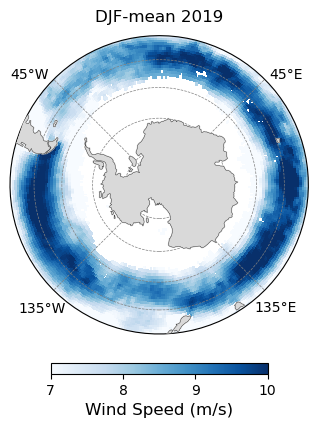

In [3]:
#### plot the southern ocean mean winds

fig, ax = plt.subplots(
    1, 1,
    figsize=(4, 5), # Adjusted figsize for two plots
    subplot_kw={'projection': ccrs.Orthographic(0, -90)}
)

ax = southern_ocean_map(ax)

img = ax.pcolormesh(ds_so_mean_no_ice.longitude, ds_so_mean_no_ice.latitude, ds_so_mean_no_ice.ws.sel(time='2019-12-01'),
               transform=ccrs.PlateCarree(), vmin=7, vmax=10, shading='auto', cmap='Blues')

cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)
cb.set_label('Wind Speed (m/s)', fontsize=12)

ax.set_title('DJF-mean 2019', pad=10)

In [4]:
storms_combined_means = xr.open_mfdataset('/home/mduplessis/data/era5/storms/combined_storms_*_seasonal_means.nc', compat='override').load()

In [5]:
# Define the threshold distance (radius) in km
threshold_distance = 1000

# Get the dimensions of the array
rows = len(storms_combined_means.y)
cols = len(storms_combined_means.x)

# Calculate the center point
center_x = rows // 2
center_y = cols // 2

# Create a new 2D array to store the result
radial_idx = np.zeros((rows, cols), dtype=int)*np.nan

# Iterate through the 2D array
for i in range(rows):
    for j in range(cols):
        # Calculate the distance from the center point
        distance = np.sqrt((storms_combined_means.x[i] - storms_combined_means.x[center_x])**2 + (storms_combined_means.y[j] - storms_combined_means.y[center_y])**2)
        # Check if the distance is within the threshold
        if distance <= threshold_distance:
            radial_idx[i][j] = 1

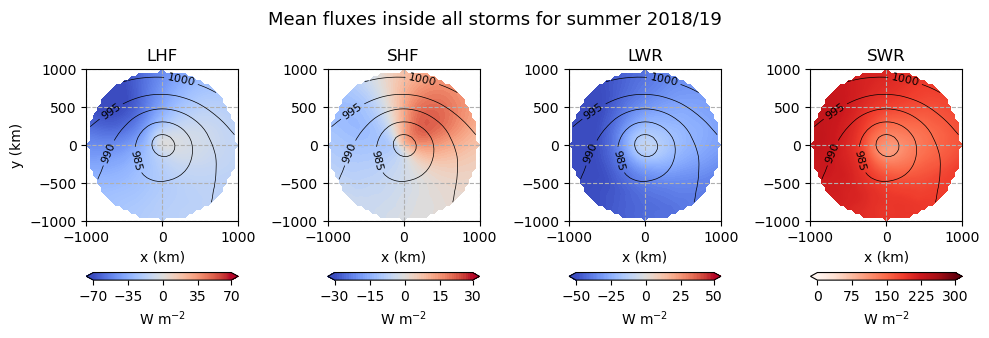

In [6]:
year = 2018

fig,ax=plt.subplots(1,4,figsize=(10,3.5))

# Define common contour levels for MSL
msl_levels = np.arange(960, 1020, 5)

# List of data variables and their respective plotting parameters
plot_params = [
    {'data': storms_combined_means.slhf, 'title': 'LHF', 'vmin': -70, 'vmax': 70, 'cmap': 'coolwarm'},
    {'data': storms_combined_means.sshf, 'title': 'SHF', 'vmin': -30, 'vmax': 30, 'cmap': 'coolwarm'},
    {'data': storms_combined_means.str, 'title': 'LWR', 'vmin': -50, 'vmax': 50, 'cmap': 'coolwarm'},
    {'data': storms_combined_means.ssr, 'title': 'SWR', 'vmin': 0, 'vmax': 300, 'cmap': 'Reds'},
]

for i, a in enumerate(ax):
    # Pcolormesh plotting
    img = a.contourf(storms_combined_means.x, storms_combined_means.y, 
                       plot_params[i]['data'].sel(year=year)*radial_idx, 
                       levels=np.arange(plot_params[i]['vmin'], plot_params[i]['vmax'], 1), 
                       cmap=plot_params[i]['cmap'], extend='both')
    
    # Colorbar for each subplot
    cb = plt.colorbar(mappable=img, ax=a, orientation='horizontal', pad=0.2)
    cb.set_label('W m$^{-2}$')
    cb.set_ticks(np.arange(plot_params[i]['vmin'], plot_params[i]['vmax'] + 1, (plot_params[i]['vmax'] - plot_params[i]['vmin'])/4))
    a.set_title(plot_params[i]['title'])

    # MSL Contours with labels
    # Store the contour object to use with clabel
    contour_msl = a.contour(storms_combined_means.x, storms_combined_means.y, 
                            storms_combined_means.msl.sel(year=year)*radial_idx, 
                            levels=msl_levels, colors='k', linewidths=0.5)
    
    # Add labels to the contours
    a.clabel(contour_msl, inline=True, fontsize=8, fmt='%1.0f') # fmt='%1.0f' formats labels as integers

    # Common axis settings
    a.set_aspect('equal')
    a.set_xlim(-1000, 1000)
    a.set_ylim(-1000, 1000)
    a.set_xlabel('x (km)')
    a.yaxis.set_ticks(np.arange(-1000, 1001, 500))
    a.grid(ls='--')

ax[0].set_ylabel('y (km)')

fig.suptitle('Mean fluxes inside all storms for summer 2018/19', fontsize=13, y=0.95)

plt.tight_layout()

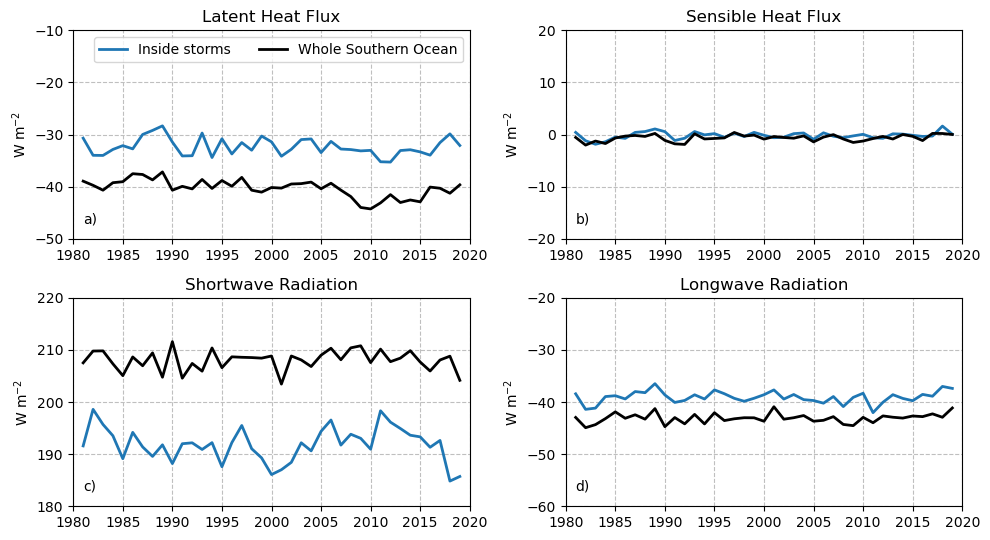

In [7]:
# plot the Southern Ocean mean flux variables

fig,ax=plt.subplots(2,2,figsize=(10,5.5))

props = dict(lw=2)

ax[0,0].plot(storms_combined_means.year, (storms_combined_means.slhf*radial_idx).mean(dim=('x', 'y')), label='Inside storms', **props)
ax[0,0].plot(storms_combined_means.year, (ds_so_mean_no_ice.slhf).mean(dim=('latitude', 'longitude')), label='Whole Southern Ocean', **props, c='k')
ax[0,0].set_title('Latent Heat Flux')

ax[0,1].plot(storms_combined_means.year, (storms_combined_means.sshf*radial_idx).mean(dim=('x', 'y')), label='Inside storms', **props)
ax[0,1].plot(storms_combined_means.year, (ds_so_mean_no_ice.sshf).mean(dim=('latitude', 'longitude')), label='Whole Southern Ocean', **props, c='k')
ax[0,1].set_title('Sensible Heat Flux')

ax[1,0].plot(storms_combined_means.year, (storms_combined_means.ssr*radial_idx).mean(dim=('x', 'y')), label='Inside storms', **props)
ax[1,0].plot(storms_combined_means.year, (ds_so_mean_no_ice.ssr).mean(dim=('latitude', 'longitude')), label='Whole Southern Ocean', **props, c='k')
ax[1,0].set_title('Shortwave Radiation')

ax[1,1].plot(storms_combined_means.year, (storms_combined_means.str*radial_idx).mean(dim=('x', 'y')), label='Inside storms', **props)
ax[1,1].plot(storms_combined_means.year, (ds_so_mean_no_ice.str).mean(dim=('latitude', 'longitude')), label='Whole Southern Ocean', **props, c='k')
ax[1,1].set_title('Longwave Radiation')

ax[0,0].set_ylim(-50,-10)
ax[0,1].set_ylim(-20, 20)
ax[1,0].set_ylim(180,220)
ax[1,1].set_ylim(-60,-20)

ax[0,0].legend(ncol=2)

for a in ax.flatten():
    a.set_xlim(1980, 2020)
    a.set_ylabel('W m$^{-2}$')
    a.grid(ls='--', c='0.75')

ax[0,0].text(1981, -47, 'a)')
ax[0,1].text(1981, -17, 'b)')
ax[1,0].text(1981, 183, 'c)')
ax[1,1].text(1981, -57, 'd)')

fig.tight_layout()

Text(0.5, 9.222222222222216, '')

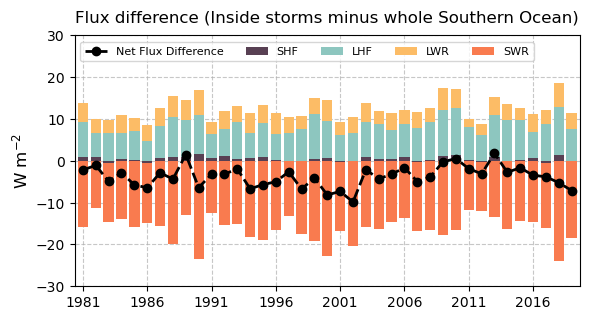

In [8]:
import pandas as pd

years = storms_combined_means.year.values
num_years = len(years)

# Calculate the storm flux differences
storm_diff_flux_str = (storms_combined_means.str*radial_idx).mean(dim=('x', 'y')).values - (ds_so_mean_no_ice.str).mean(dim=('latitude', 'longitude')).values
storm_diff_flux_ssr = (storms_combined_means.ssr*radial_idx).mean(dim=('x', 'y')).values - (ds_so_mean_no_ice.ssr).mean(dim=('latitude', 'longitude')).values
storm_diff_flux_slhf = (storms_combined_means.slhf*radial_idx).mean(dim=('x', 'y')).values - (ds_so_mean_no_ice.slhf).mean(dim=('latitude', 'longitude')).values
storm_diff_flux_sshf = (storms_combined_means.sshf*radial_idx).mean(dim=('x', 'y')).values - (ds_so_mean_no_ice.sshf).mean(dim=('latitude', 'longitude')).values

# --- Prepare Data for Plotting with Pandas DataFrame ---
# Create a pandas DataFrame to hold the flux differences.
# This replaces the xarray Dataset 'flux_data'.
flux_data_df = pd.DataFrame({
    'SWR': storm_diff_flux_ssr,
    'LWR': storm_diff_flux_str,    
    'LHF': storm_diff_flux_slhf,
    'SHF': storm_diff_flux_sshf
}, index=years)

flux_data_df.index.name = 'year'

# Calculate the net flux difference by summing the columns of the DataFrame
storm_diff_flux_net = flux_data_df.sum(axis=1)

# --- Create the Stacked Bar Chart with Pandas Plotting ---
fig, ax = plt.subplots(figsize=(6, 3.5))

# Define the order of the flux types for stacking and legend
flux_types = ['SHF', 'LHF', 'LWR', 'SWR']

# Get colors from the chosen colormap (cmocean.thermal_r)
colors = cmo.thermal_r(np.linspace(0.2, 0.8, len(flux_types)))

colors = ['#584053', '#8DC6BF', '#FCBC66', '#F97B4F']  # Custom colors for each flux type

# Plot the stacked bar chart using pandas.DataFrame.plot
# The 'stacked=True' argument automatically handles the stacking.
# We explicitly select the columns in 'flux_types' order to ensure consistent coloring.
flux_data_df[flux_types].plot(
    kind='bar',      # Specifies a bar chart
    stacked=True,    # Stacks the bars
    ax=ax,           # Plots on the pre-defined matplotlib axes
    color=colors,    # Assigns colors to each stack
    width=0.8,       # Adjusts the width of the bars
    legend=False,     # We will create a combined legend later
    zorder=100
)

# Add the net flux difference line
ax.plot(
    range(len(flux_data_df.index)), # Use integer positions for x-axis to align with bars
    storm_diff_flux_net,
    color='black',
    linewidth=2,
    label='Net Flux Difference',
    marker='o',
    linestyle='--',
    zorder=101
)

ax.set_ylim(-30, 30)

# --- Customize the Plot ---
plt.title('Flux difference (Inside storms minus whole Southern Ocean)', fontsize=12, pad=10)
plt.ylabel('W m$^{-2}$', fontsize=12)

# Set x-ticks to be the actual years and rotate their labels for readability
# Calculate positions for ticks every 5 years
tick_positions = np.arange(0, len(flux_data_df.index), 5)
# Get the corresponding year labels
tick_labels = flux_data_df.index[tick_positions].astype(str)

ax.set_xticks(tick_positions) # Set tick positions based on the 5-year interval
ax.set_xticklabels(tick_labels, rotation=0, ha='center') # Set labels and rotate

# Combine handles and labels from both the bar plot and the line plot for a single legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0.0, 0.995), loc='upper left', ncol=5, fontsize=8) # Place legend outside the plot

plt.grid(axis='both', linestyle='--', alpha=0.7, zorder=0) # Add a grid for better readability of y-values
plt.tight_layout() # Adjust layout to prevent labels from overlapping

ax.set_xlabel('')

In [9]:
ds_sst_summer = xr.open_dataset('/home/mduplessis/data/noaa_sst_seasonal.nc')

In [10]:
np.round(np.corrcoef(storm_diff_flux_net, ds_sst_summer.sst_max.mean(dim=(('latitude', 'longitude'))))[0,1], 2)

np.float64(0.28)

In [11]:
storms_combined_means['qnet'] = storms_combined_means.slhf + storms_combined_means.sshf + storms_combined_means.str + storms_combined_means.ssr

In [12]:
# Calculate the mean net flux inside storms and for the Southern Ocean
qnet_mean_storms = storms_combined_means.mean(dim=('x', 'y')).qnet
qnet_mean_so = (ds_so_mean_no_ice.qnet).mean(dim=('latitude', 'longitude'))

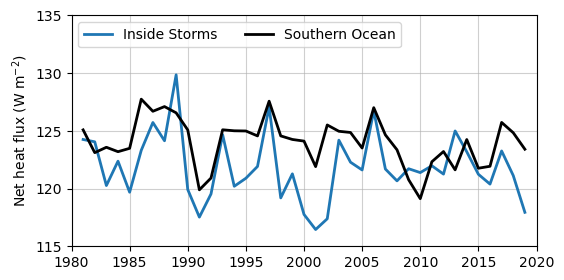

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))

# Plot on the first y-axis (ax)
ax.plot(ds_sst_summer.years, qnet_mean_storms, lw=2, label='Inside Storms', zorder=10)
ax.plot(ds_sst_summer.years, qnet_mean_so, lw=2, c='k', label='Southern Ocean', zorder=10)

ax.set_ylabel('Net heat flux (W m$^{-2}$)', fontsize=10)

ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=3, frameon=True) # 'frameon=False' removes the legend box
plt.grid(alpha=0.6)

ax.set_xlim(1980, 2020)
ax.set_ylim(115, 135)
ax.yaxis.set_ticks(np.arange(115, 136, 5))


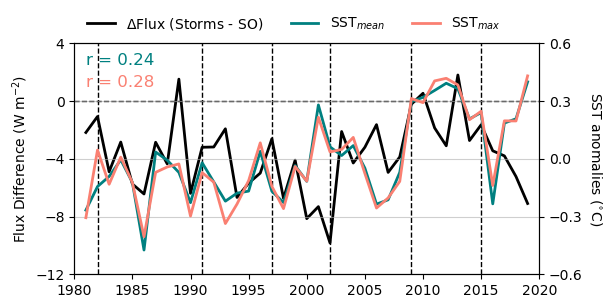

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

# Plot on the first y-axis (ax)
line1, = ax.plot(ds_sst_summer.years, storm_diff_flux_net, lw=2, c='k', label='$\Delta$Flux (Storms - SO)')

sst_mean_anomaly = ds_sst_summer.sst_mean.mean(dim=(('latitude', 'longitude'))) - ds_sst_summer.sst_mean.mean(dim=(('latitude', 'longitude'))).mean()
sst_max_anomaly = ds_sst_summer.sst_max.mean(dim=(('latitude', 'longitude'))) - ds_sst_summer.sst_max.mean(dim=(('latitude', 'longitude'))).mean()

# Create the second y-axis (ax1) and plot on it
ax1 = ax.twinx()
line2, = ax1.plot(ds_sst_summer.years, sst_mean_anomaly, c='teal', lw=2, ls='-', label='SST$_{mean}$')
line3, = ax1.plot(ds_sst_summer.years, sst_max_anomaly, c='salmon', lw=2, ls='-', label='SST$_{max}$')

ax.set_ylabel('Flux Difference (W m$^{-2}$)', fontsize=10)
ax1.set_ylabel('SST anomalies ($^{\circ}$C)', fontsize=10, rotation=270, labelpad=15)

# --- Legend Creation ---
# Collect handles and labels from both axes
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0, 1.175), ncol=3, frameon=False) # 'frameon=False' removes the legend box
plt.grid(alpha=0.6)

ax.set_xlim(1980, 2020)

ax.set_ylim(-12, 4)
ax.yaxis.set_ticks(np.arange(-12, 8, 4))
ax1.set_ylim(-0.6, 0.6)
ax1.yaxis.set_ticks(np.arange(-0.6, 0.9, 0.3))

r = np.round(np.corrcoef(storm_diff_flux_net, sst_mean_anomaly)[0,1], 2)
ax.text(1981, 2.5, 'r = ' + str(r), fontsize=12, color='teal')

r = np.round(np.corrcoef(storm_diff_flux_net, sst_max_anomaly)[0,1], 2)
ax.text(1981, 1.0, 'r = ' + str(r), fontsize=12, color='salmon')

ax.axhline(0, color='k', lw=1, ls='--')

ax.axvline(1982, color='k', lw=1, ls='--', label='2015')
ax.axvline(1991, color='k', lw=1, ls='--', label='2015')
ax.axvline(1997, color='k', lw=1, ls='--', label='2015')
ax.axvline(2002, color='k', lw=1, ls='--', label='2015')
ax.axvline(2009, color='k', lw=1, ls='--', label='2015')
ax.axvline(2015, color='k', lw=1, ls='--', label='2015')

In [15]:
np.corrcoef(sst_mean_anomaly, sst_max_anomaly)

array([[1.        , 0.96988419],
       [0.96988419, 1.        ]])

In [16]:
sst_flux_corr = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])

for i, ln in enumerate(ds_so_mean_no_ice.longitude):

    for j, lt in enumerate(ds_so_mean_no_ice.latitude):

        sst_flux_corr[j,i] = np.corrcoef(ds_so_mean_no_ice.qnet.values[:,j,i], ds_sst_summer.sst_max.values[:,j,i])[0,1]

#### Correlation map of SST and winds

In [17]:
from scipy.stats import pearsonr

sst_wind_corr = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])
sst_wind_corr_pval = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])


for i, ln in enumerate(ds_so_mean_no_ice['ws'].longitude):

    for j, lt in enumerate(ds_so_mean_no_ice['ws'].latitude):

        ws_values = ds_so_mean_no_ice['ws'].values[:,j,i]
        sst_values = ds_sst_summer.sst_max.values[:,j,i]

        # Calculate the Pearson correlation coefficient and the p-value
        correlation_coefficient, p_value = pearsonr(ws_values, sst_values)

        sst_wind_corr[j,i] = correlation_coefficient

        sst_wind_corr_pval[j,i] = p_value

In [18]:
ds_corr = xr.Dataset(
    {
        'sst_wind_corr': (['latitude', 'longitude'], sst_wind_corr),
        'sst_wind_corr_pval': (['latitude', 'longitude'], sst_wind_corr_pval)
    },
    coords={
        'latitude': ds_so_mean_no_ice.latitude,
        'longitude': ds_so_mean_no_ice.longitude
    }
)

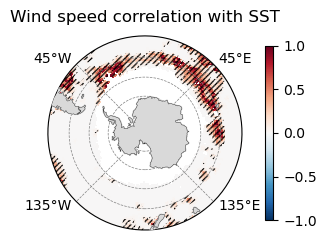

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_wind_corr_pval, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds_corr.longitude, ds_corr.latitude)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_wind_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

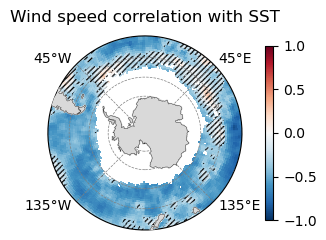

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_wind_corr, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_wind_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

#### Correlation map of SST and fluxes

In [21]:
from scipy.stats import pearsonr

sst_flux_corr = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])
sst_flux_corr_pval = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])


for i, ln in enumerate(ds_so_mean_no_ice['qnet'].longitude):

    for j, lt in enumerate(ds_so_mean_no_ice['qnet'].latitude):

        ws_values = ds_so_mean_no_ice['qnet'].values[:,j,i]
        sst_values = ds_sst_summer.sst_max.values[:,j,i]

        # Calculate the Pearson correlation coefficient and the p-value
        correlation_coefficient, p_value = pearsonr(ws_values, sst_values)

        sst_flux_corr[j,i] = correlation_coefficient

        sst_flux_corr_pval[j,i] = p_value

In [22]:
ds_corr = xr.Dataset(
    {
        'sst_flux_corr': (['latitude', 'longitude'], sst_flux_corr),
        'sst_flux_corr_pval': (['latitude', 'longitude'], sst_flux_corr_pval)
    },
    coords={
        'latitude': ds_so_mean_no_ice.latitude,
        'longitude': ds_so_mean_no_ice.longitude
    }
)

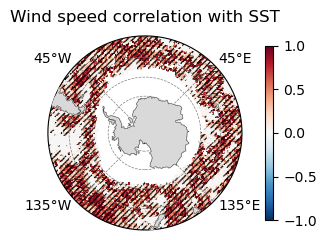

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_flux_corr_pval, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds_corr.longitude, ds_corr.latitude)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_flux_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

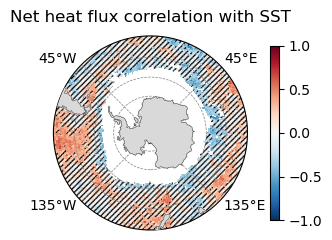

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_flux_corr, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

ax = southern_ocean_map(ax)

ax.set_title('Net heat flux correlation with SST', pad=10)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_flux_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

#### Interannual correlation between fluxes inside storms and whole Southern Ocean

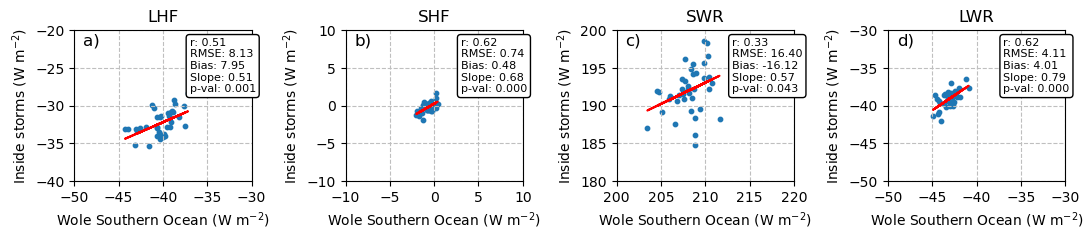

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

# Function to calculate statistics
def calculate_statistics(x, y):
    correlation = np.corrcoef(x, y)[0, 1]
    rmse = np.sqrt(mean_squared_error(x, y))
    bias = np.mean(y - x)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return correlation, rmse, bias, slope, p_value, intercept

# Create scatter plots with statistics
fig, ax = plt.subplots(1, 4, figsize=(11, 2.5))

variables = ['slhf', 'sshf', 'ssr', 'str']
titles = ['LHF', 'SHF', 'SWR', 'LWR']
ylims = [(-40, -20), (-10, 10), (180, 200), (-50, -30)]
xlims = [(-50, -30), (-10, 10), (200, 220), (-50, -30)]

for i in range(4):
   
    var = variables[i]
    inside_storms = (storms_combined_means[var] * radial_idx).mean(dim=('x', 'y'))[:38]
    whole_so = ds_so_mean_no_ice[var].mean(dim=('latitude', 'longitude'))[:38]
    
    ax[i].scatter(whole_so, inside_storms, s=10)

    correlation, rmse, bias, slope, p_value, intercept = calculate_statistics(whole_so, inside_storms)
    stats_text = f'r: {correlation:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}\nSlope: {slope:.2f}\np-val: {p_value:.3f}'
    
    ax[i].text(0.65, 0.95, stats_text, transform=ax[i].transAxes,
                  fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    # Add line of best fit
    ax[i].plot(whole_so, slope * whole_so + intercept, color='red')
    
    ax[i].set_title(titles[i])
    ax[i].set_ylim(ylims[i])
    ax[i].set_xlim(xlims[i])
    ax[i].set_xlabel('Wole Southern Ocean (W m$^{-2}$)')
    ax[i].set_ylabel('Inside storms (W m$^{-2}$)')
    ax[i].grid(ls='--', c='0.75')

ax[0].text(0.05, 0.9, 'a)', transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.05, 0.9, 'b)', transform=ax[1].transAxes, fontsize=12)
ax[2].text(0.05, 0.9, 'c)', transform=ax[2].transAxes, fontsize=12)         
ax[3].text(0.05, 0.9, 'd)', transform=ax[3].transAxes, fontsize=12)

fig.tight_layout()

plt.show()


#### Frequency and intensity of storms correlation with heat flux

In [26]:
ds_storms_shf = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_sensible_heat_flux_no_ice.nc')
ds_storms_slhf = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_latent_heat_flux_no_ice.nc')
ds_storms_ssr = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_net_solar_radiation_no_ice.nc')
ds_storms_str = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_net_thermal_radiation_no_ice.nc')

In [27]:
ds_storms = xr.merge([ds_storms_shf, ds_storms_slhf, ds_storms_ssr, ds_storms_str], compat='override')

In [29]:
import datetime

year = 2018

start_time_dt = datetime.datetime(year, 12, 1)
end_time_dt = datetime.datetime(year + 1, 3, 1)

start_time_np = np.datetime64(start_time_dt)
end_time_np = np.datetime64(end_time_dt)

# Boolean indexing for time selection
time_idx = (ds_storms.time >= start_time_np) & (ds_storms.time < end_time_np)
# Select the data for the current winter season
ds_season = ds_storms.isel(time=time_idx)

In [33]:
shf = ds_season['sshf'] / 3600  # Convert from J to W m^-2
shf_mean_storm = shf.mean(dim=('y', 'x'))

lhf = ds_season['slhf'] / 3600  # Convert from J to W m^-2
lhf_mean_storm = lhf.mean(dim=('y', 'x'))

ssr = ds_season['ssr'] / 3600  # Convert from J to W m^-2
ssr_mean_storm = ssr.mean(dim=('y', 'x'))

str = ds_season['str'] / 3600  # Convert from J to W m^-2
str_mean_storm = str.mean(dim=('y', 'x'))


Text(0.5, 1.0, 'Mean SHF 2018/19 in storms')

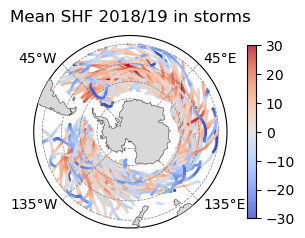

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = plt.scatter(ds_season.lon, ds_season.lat, c=shf_mean_storm, 
            cmap='coolwarm', vmin=-30, vmax=30, s=1, alpha=0.8, transform=ccrs.PlateCarree())
plt.colorbar(img, shrink=0.9, pad=0.075)

ax = southern_ocean_map(ax)

ax.set_title('Mean SHF 2018/19 in storms', pad=10)

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

In [31]:
lon = ds_season.lon.values.copy()
lon[lon > 180] -= 360

/tmp/ipykernel_636147/2602684565.py:23: RuntimeWarning: invalid value encountered in divide
  mean_shf_gridded = np.where(count_shf > 0, sum_shf / count_shf, np.nan)


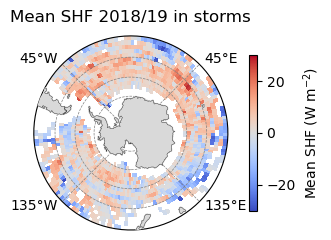

In [35]:
# --- Start of your actual solution ---

# 1. Define the new 2x2 degree grid
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, -40 # Southern Ocean relevant range

# Create 2x2 degree bins
lon_bins = np.arange(lon_min, lon_max + 2, 2)
lat_bins = np.arange(lat_min, lat_max + 2, 2)

# 2. Bin the data
# histogram2d returns: H (sum of values in bins), xedges, yedges
# We sum shf_mean_storm for each bin
sum_shf, _, _ = np.histogram2d(ds_season.lat, lon,
                                 bins=[lat_bins, lon_bins], weights=shf_mean_storm)

# We also need to count how many data points fall into each bin
count_shf, _, _ = np.histogram2d(ds_season.lat, lon,
                                 bins=[lat_bins, lon_bins])

# 3. Calculate the mean for each bin
# Avoid division by zero for empty bins
mean_shf_gridded = np.where(count_shf > 0, sum_shf / count_shf, np.nan)

# Get the center of the bins for pcolormesh
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

# Create 2D meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_bins, lat_bins) # Use bin edges for pcolormesh

# --- Plotting ---
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5),
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Use pcolormesh with the gridded data and the bin edges
img = ax.pcolormesh(lon_mesh, lat_mesh, mean_shf_gridded,
                    cmap='coolwarm', vmin=-30, vmax=30,
                    transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.8, pad=0.075, label='Mean SHF (W m$^{-2}$)')

ax = southern_ocean_map(ax) # Apply your map features

ax.set_title('Mean SHF 2018/19 in storms', pad=10)

fig.tight_layout()
plt.show()


/tmp/ipykernel_636147/1090929031.py:16: RuntimeWarning: invalid value encountered in divide
  mean_flux_gridded = np.where(count_flux > 0, sum_flux / count_flux, np.nan)
/tmp/ipykernel_636147/1090929031.py:16: RuntimeWarning: invalid value encountered in divide
  mean_flux_gridded = np.where(count_flux > 0, sum_flux / count_flux, np.nan)
/tmp/ipykernel_636147/1090929031.py:16: RuntimeWarning: invalid value encountered in divide
  mean_flux_gridded = np.where(count_flux > 0, sum_flux / count_flux, np.nan)
/tmp/ipykernel_636147/1090929031.py:16: RuntimeWarning: invalid value encountered in divide
  mean_flux_gridded = np.where(count_flux > 0, sum_flux / count_flux, np.nan)


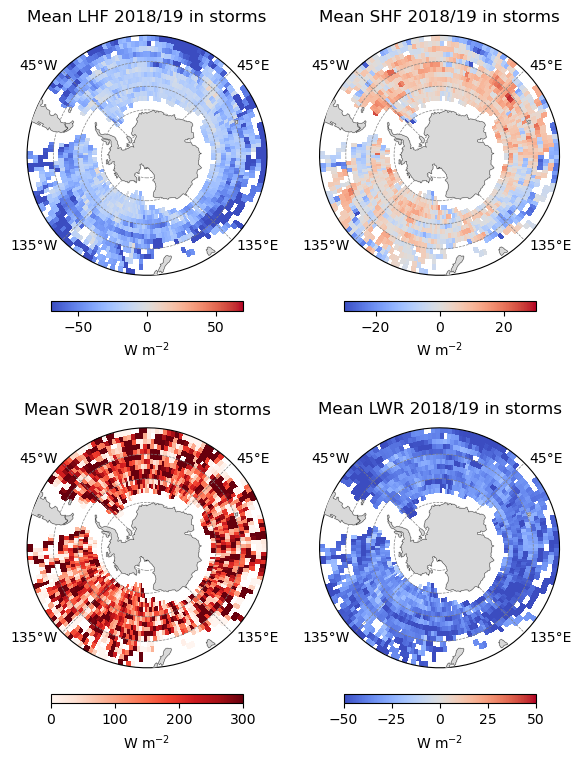

In [39]:
# Adjust longitude values from 0-360 to -180-180
lon = np.copy(ds_season.lon) # Create a copy to avoid modifying original ds_season.lon
lon[lon > 180] -= 360

# --- Gridding Function ---
def grid_scattered_data(lat_data, lon_data, flux_data, lat_bins, lon_bins):
    """
    Grids scattered data onto a 2D grid by calculating the mean within each bin.
    """
    sum_flux, _, _ = np.histogram2d(lat_data, lon_data,
                                    bins=[lat_bins, lon_bins], weights=flux_data)
    count_flux, _, _ = np.histogram2d(lat_data, lon_data,
                                    bins=[lat_bins, lon_bins])
    
    # Calculate the mean for each bin, handling empty bins
    mean_flux_gridded = np.where(count_flux > 0, sum_flux / count_flux, np.nan)
    return mean_flux_gridded

# --- Main Plotting Setup ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 8), # Increased figsize for 4 subplots
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Define common grid bins
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, -40
lon_bins = np.arange(lon_min, lon_max + 2, 2)
lat_bins = np.arange(lat_min, lat_max + 2, 2)

# Create 2D meshgrid for plotting (using bin edges for pcolormesh)
lon_mesh, lat_mesh = np.meshgrid(lon_bins, lat_bins)

# List of variables to plot
plot_variables = [
    {'name': 'lhf', 'data': lhf_mean_storm, 'title': 'Mean LHF 2018/19 in storms', 'cmap': 'coolwarm', 'vmin': -70, 'vmax': 70},
    {'name': 'shf', 'data': shf_mean_storm, 'title': 'Mean SHF 2018/19 in storms', 'cmap': 'coolwarm', 'vmin': -30, 'vmax': 30},
    {'name': 'ssr', 'data': ssr_mean_storm, 'title': 'Mean SWR 2018/19 in storms', 'cmap': 'Reds', 'vmin': 0, 'vmax': 300},
    {'name': 'str', 'data': str_mean_storm, 'title': 'Mean LWR 2018/19 in storms', 'cmap': 'coolwarm', 'vmin': -50, 'vmax': 50},
]

for i, ax in enumerate(axes.flat): # Use axes.flat to iterate through 1D array of subplots
    var_info = plot_variables[i]
    
    # Grid the current variable's data
    gridded_data = grid_scattered_data(ds_season.lat, lon, var_info['data'], lat_bins, lon_bins)
    
    # Plot using pcolormesh
    img = ax.pcolormesh(lon_mesh, lat_mesh, gridded_data,
                        cmap=var_info['cmap'], vmin=var_info['vmin'], vmax=var_info['vmax'],
                        transform=ccrs.PlateCarree())
    
    # Add colorbar for each subplot
    cbar = plt.colorbar(img, ax=ax, shrink=0.8, pad=0.075, orientation='horizontal')
    cbar.set_label('W m$^{-2}$') # Units are likely the same for all heat fluxes

    ax = southern_ocean_map(ax) # Apply map features to current subplot

    ax.set_title(var_info['title'], pad=10, fontsize=12) # Reduced font size for titles

fig.tight_layout()
plt.show()

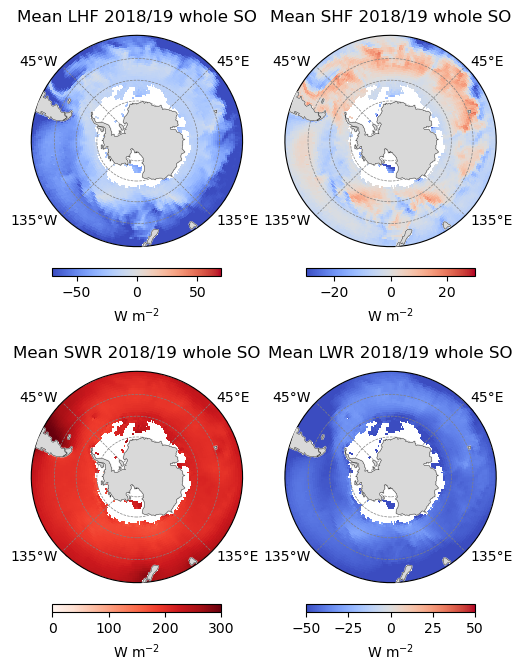

In [42]:
# --- Main Plotting Setup ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 8), # Increased figsize for 4 subplots
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

# List of variables to plot
plot_variables = [
    {'name': 'slhf', 'data': ds_so_mean_no_ice, 'title': 'Mean LHF 2018/19 whole SO', 'cmap': 'coolwarm', 'vmin': -70, 'vmax': 70},
    {'name': 'sshf', 'data': ds_so_mean_no_ice, 'title': 'Mean SHF 2018/19 whole SO', 'cmap': 'coolwarm', 'vmin': -30, 'vmax': 30},
    {'name': 'ssr', 'data': ds_so_mean_no_ice, 'title': 'Mean SWR 2018/19 whole SO', 'cmap': 'Reds', 'vmin': 0, 'vmax': 300},
    {'name': 'str', 'data': ds_so_mean_no_ice, 'title': 'Mean LWR 2018/19 whole SO', 'cmap': 'coolwarm', 'vmin': -50, 'vmax': 50},
]

for i, ax in enumerate(axes.flat): # Use axes.flat to iterate through 1D array of subplots
    var_info = plot_variables[i]
        
    # Plot using pcolormesh
    img = ax.pcolormesh(ds_so_mean_no_ice.longitude, ds_so_mean_no_ice.latitude, var_info['data'][var_info['name']].mean(dim=('time')),
                        cmap=var_info['cmap'], vmin=var_info['vmin'], vmax=var_info['vmax'],
                        transform=ccrs.PlateCarree())
    
    # Add colorbar for each subplot
    cbar = plt.colorbar(img, ax=ax, shrink=0.8, pad=0.075, orientation='horizontal')
    cbar.set_label('W m$^{-2}$') # Units are likely the same for all heat fluxes

    ax = southern_ocean_map(ax) # Apply map features to current subplot

    ax.set_title(var_info['title'], pad=10, fontsize=12) # Reduced font size for titles
    

#### Storm impacts on winds

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_scatter_stats(ax, var1, var2, title, xlabel, ylabel, xlim, ylim):
    """
    Plot sensible heat flux vs. mean pressure with a line of best fit and confidence interval shading.

    Parameters:
    mean_pressure (array-like): Array of mean pressure values.
    shf_values (array-like): Array of sensible heat flux values.
    shf_mean (float): Mean sensible heat flux value.
    """

    # Scatter plot
    ax.scatter(var1, var2, s=10)
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel(ylabel, labelpad=10)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(var1, var2)

    # Plot the line of best fit
    line = slope * var1 + intercept
    ax.plot(var1, line, color='red')

    # Calculate confidence intervals
    pred = intercept + slope * var1
    se_line = std_err * np.sqrt(1/len(var1) + (var1 - np.mean(var1))**2 / np.sum((var1 - np.mean(var1))**2))
    ci_upper = pred + 1.96 * se_line
    ci_lower = pred - 1.96 * se_line

    # Plot confidence interval shading
    sorted_indices = np.argsort(var1)
    ax.fill_between(var1[sorted_indices], ci_upper[sorted_indices], ci_lower[sorted_indices], color='red', alpha=0.2)

    # Add text for the regression statistics
    textstr = '\n'.join((
        f'Slope: {slope:.2f}',
        f'R: {r_value:.2f}',
        f'P-value: {p_value:.2f}',
        f'Std error: {std_err:.2f}'
    ))
    ax.text(0.6, 0.3, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1, facecolor='k'))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.yaxis.set_ticks(np.arange(-8, 12, 4))
    
    ax.set_title(title, fontsize=12)

# Example usage
# mean_pressure = np.array([...])  # Replace with your data
# shf_values = storm_mean_ds.mean(dim='x').mean(dim='y').shf - shf_mean  # Replace with your data

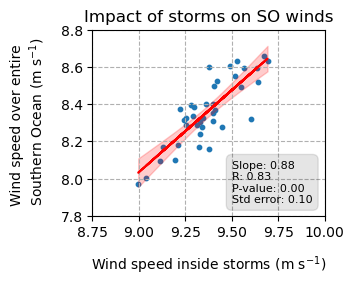

In [11]:
fig,ax = plt.subplots(figsize=(3,3))

plot_scatter_stats(ax=ax, var1=storms_combined_means['ws'].mean(dim=('x', 'y')).data, var2=ds_so_mean_no_ice.mean(dim=('latitude', 'longitude'))['ws'].data, 
                   title='Impact of storms on SO winds', xlabel='Wind speed inside storms (m s$^{-1}$)', ylabel='Wind speed over entire \n Southern Ocean (m s$^{-1}$)', xlim=[8.75,10], ylim=[7.8,8.8])

ax.grid(ls='--')
ax.set_aspect('equal')

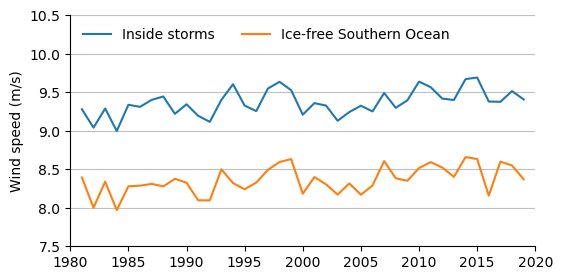

In [12]:
# wind inside storms or across the southern ocean

fig,ax = plt.subplots(figsize=(6,3))

ax.plot(storms_combined_means['year'], storms_combined_means['ws'].mean(dim=('x', 'y')), label='Inside storms')
ax.plot(storms_combined_means['year'], ds_so_mean_no_ice.mean(dim=('latitude', 'longitude'))['ws'], label='Ice-free Southern Ocean')

ax.legend(loc=2, ncol=2, frameon=False)

ax.set_xlim(1980, 2020)
ax.set_ylim(7.5, 10.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Wind speed (m/s)')

ax.grid(c='0.75')

# Add grid with only horizontal lines
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/winds_storms_whole_so.png', dpi=500)

In [13]:
sst = xr.open_dataset('/home/mduplessis/data/noaa_sst_seasonal.nc')

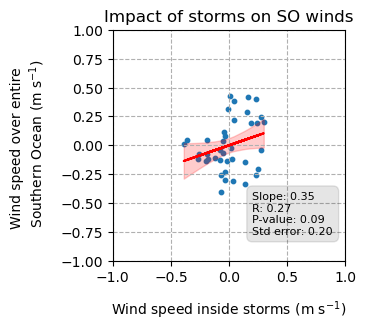

In [14]:
# plot the sst relationship wind the winds

sst_data = sst.sst_max.mean(dim=('latitude', 'longitude')).data
storm_winds = (storms_combined_means['ws']*radial_idx).mean(dim=('x', 'y')).data
so_winds = ds_so_mean_no_ice.mean(dim=('latitude', 'longitude'))['ws'].data

fig,ax = plt.subplots(figsize=(3,3))

plot_scatter_stats(ax=ax, 
                   var1=so_winds-np.mean(so_winds), 
                   var2=sst_data-np.mean(sst_data), 
                   title='Impact of storms on SO winds', 
                   xlabel='Wind speed inside storms (m s$^{-1}$)', 
                   ylabel='Wind speed over entire \n Southern Ocean (m s$^{-1}$)', 
                   xlim=[-1,1], ylim=[-1, 1]
                   )

ax.grid(ls='--')
# ax.set_aspect('equal')

In [15]:
from scipy.stats import pearsonr

sst_wind_corr = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])
sst_wind_corr_pval = np.ndarray([ds_so_mean_no_ice.latitude.size, ds_so_mean_no_ice.longitude.size])


for i, ln in enumerate(ds_so_mean_no_ice['ws'].longitude):

    for j, lt in enumerate(ds_so_mean_no_ice['ws'].latitude):

        ws_values = ds_so_mean_no_ice['ws'].values[:,j,i]
        sst_values = sst.sst_max.values[:,j,i]

        # Calculate the Pearson correlation coefficient and the p-value
        correlation_coefficient, p_value = pearsonr(ws_values, sst_values)

        sst_wind_corr[j,i] = correlation_coefficient

        sst_wind_corr_pval[j,i] = p_value

In [16]:
ds_corr = xr.Dataset(
    {
        'sst_wind_corr': (['latitude', 'longitude'], sst_wind_corr),
        'sst_wind_corr_pval': (['latitude', 'longitude'], sst_wind_corr_pval)
    },
    coords={
        'latitude': ds_so_mean_no_ice.latitude,
        'longitude': ds_so_mean_no_ice.longitude
    }
)

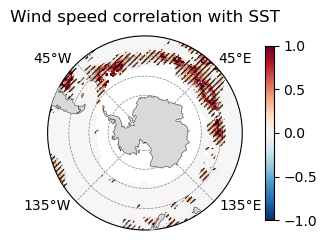

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_wind_corr_pval, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds_corr.longitude, ds_corr.latitude)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_wind_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

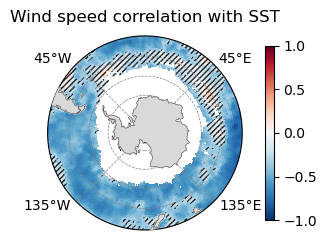

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(ds_corr.longitude, ds_corr.latitude, ds_corr.sst_wind_corr, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

# Add stippling where p-values are larger than 0.05
zm = np.ma.masked_less(ds_corr.sst_wind_corr_pval, 0.05)

img = ax.pcolor(ds_corr.longitude, ds_corr.latitude, zm, hatch='//////', alpha=0, transform=ccrs.PlateCarree())

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

In [19]:
sst_data = sst.sst_max.values
so_winds = ds_so_mean_no_ice['ws'].values

In [20]:
# Create a mask where sst_wind_corr_pval > 0.05
mask = sst_wind_corr_pval > 0.05
# Expand the mask to match the shape of sst_data
expanded_mask = np.broadcast_to(mask, sst_data.shape)

# Set sst_data to NaN where the mask is True
sst_data[expanded_mask] = np.nan
so_winds[expanded_mask] = np.nan

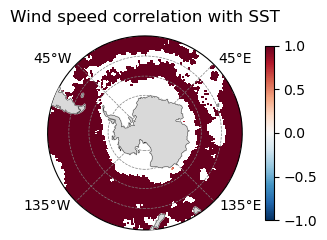

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 2.5), subplot_kw={'projection': ccrs.SouthPolarStereo()})

img = ax.pcolormesh(sst.longitude, sst.latitude, sst_data[1], cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

plt.colorbar(img, shrink=0.9, pad=0.075)

ax = southern_ocean_map(ax)

ax.set_title('Wind speed correlation with SST', pad=10)

fig.tight_layout()

# plt.savefig('/home/mduplessis/projects/duplessis-storms-warming/figs/wind_corr_sst.png', dpi=500)

In [22]:
so_winds.shape

(39, 50, 360)

In [23]:
np.nanmean(so_winds, axis=(1,2))

array([8.3491764 , 7.90163867, 8.26881198, 7.90119348, 8.23885282,
       8.20561449, 8.21644218, 8.27738123, 8.34871902, 8.29814934,
       8.00105145, 8.03509307, 8.41559809, 8.27074655, 8.2272483 ,
       8.25560176, 8.36834001, 8.53730041, 8.55370871, 8.12509779,
       8.35426931, 8.2848923 , 8.0623747 , 8.20972512, 8.10770879,
       8.18100575, 8.4987295 , 8.30037697, 8.27954048, 8.51429913,
       8.49873086, 8.44248302, 8.35026369, 8.59923064, 8.55558725,
       8.03581417, 8.53815009, 8.45594886, 8.30080317])

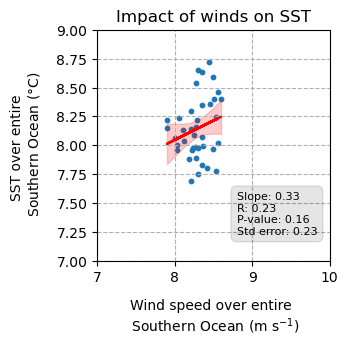

In [24]:
# plot the sst relationship wind the winds

fig,ax = plt.subplots(figsize=(3,3))

plot_scatter_stats(ax=ax, 
                   var1=np.nanmean(so_winds, axis=(1,2)), 
                   var2=np.nanmean(sst_data, axis=(1,2)), 
                   title='Impact of winds on SST', 
                   xlabel='Wind speed over entire \n Southern Ocean (m s$^{-1}$)', 
                   ylabel='SST over entire \n Southern Ocean ($\degree$C)', 
                   xlim=[7,10], ylim=[7, 9]
                   )

ax.grid(ls='--')